In [1]:
import os,sys
sys.path.append('./hmvec-master/')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
from compute_power_spectra import *
from plotting import *
from params import *

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
from scipy.ndimage import gaussian_filter1d

In [3]:
ellMax = 9600
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_gas
model = modelParams_gas
rscale = False

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

baseline = ghztoev(30)

ztype = [2., 6., 10.]
zreio = 6.
nZs = 50

compute_noise = False
compute_BB_noise = False

fsky = [0.7, 0.5, 0.5]


In [4]:
avtaulist = np.zeros((len(ztype), len(dictKey))) 
tauMWlist = np.zeros(len(dictKey))
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening = np.zeros((len(ztype), len(dictKey), 4, ellMax))
Survey = np.zeros((len(dictKey), ellMax))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, model)
        zMax = min(ztest, zMax)

        data = import_data(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
        rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

        avtaulist[zind, mind]  = 4.*np.pi * avtau/baseline
        dtaudzlist[zind, mind] = 4.*np.pi * dtaudz/baseline
        tauMWlist[mind]        = probMW/baseline
        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H

        CellTauTau[zind, mind] = (avtaulist[zind, mind]/(4*np.pi))**2. * (Cell1H + Cell2H)
        Screening[zind, mind]  = (avtaulist[zind, mind]/(4*np.pi))**2. * CMBDP

for mind, MA in enumerate(dictKey):
    Survey[mind] = (avtaulist[1, mind]/(4*np.pi))**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])


In [5]:
MA = dictKey[25]

zMin, zMax, rMin, rMax = chooseModel(MA, model)
zMax = min(zreio, zMax)

data = import_data_thomson(nZs, zMin, zMax, ellMax, getgas, rscale)
thom_probell, thom_Cell1Hdata, thom_Cell2Hdata, thom_Screening = data

thom_zsList     = np.linspace(zMin,zMax,nZs)
thom_CellTauTau = thom_Cell1Hdata + thom_Cell2Hdata


In [6]:
cross_Cell1H, cross_Cell2H, cross_CellTTau = np.zeros((3, len(dictKey), ellMax))
cross_Screening = np.zeros((len(dictKey), 4, ellMax))
bispTTT, bispTEB = np.zeros((2, len(dictKey), 3))

for mind, MA in enumerate(dictKey):    
    zMin, zMax, rMin, rMax = chooseModel(MA, model)
    zMax = min(zreio, zMax)

    data = import_data_thomsoncrosstau(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
    crossCell1H, crossCell2H, crossCMBDP = data

    cross_Cell1H[mind] = crossCell1H
    cross_Cell2H[mind] = crossCell2H
    cross_CellTTau[mind]  = (avtaulist[1, mind]/(4*np.pi)) * (crossCell1H + crossCell2H) / ((4.*np.pi) / (2.*ells+1.))**0.5
    cross_Screening[mind] = (avtaulist[1, mind]/(4*np.pi)) * crossCMBDP / ((4.*np.pi) / (2.*ells+1.))**0.5

    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        bisp = np.load(bispec_Tdsc_Tsc_Tsc(MA, nZs, zMin, zMax, ellMax, rscale, expname))
        bispTTT[mind, eind] = 0.35 * ((avtaulist[1, mind]/(4*np.pi))**2. * bisp)**-0.25

        bisp = np.load(bispec_Tdsc_Esc_Bsc(MA, nZs, zMin, zMax, ellMax, rscale, expname))
        bispTEB[mind, eind] = 0.35 * ((avtaulist[1, mind]/(4*np.pi))**2. * bisp)**-0.25


In [7]:
NFW_tauMWlist = np.zeros(len(dictKey_NFW))
NFW_avtaulist = np.zeros((len(ztype), len(dictKey_NFW))) 
NFW_dtaudzlist, NFW_zsList = np.zeros((2, len(ztype), len(dictKey_NFW), 50))
NFW_Cell1Hdata, NFW_Cell2Hdata, NFW_CellTauTau = np.zeros((3, 3, len(dictKey_NFW), ellMax))
NFW_Screening = np.zeros((len(ztype), len(dictKey_NFW), 4, ellMax))
NFW_Survey = np.zeros((len(dictKey_NFW), ellMax))

for mind, MA in enumerate(dictKey_NFW):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, modelParams_NFW)
        zMax = min(ztest, zMax)

        bool = True
        try:
            data = import_data(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data
        except:
            bool = False
            data = import_data_short(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H = data
            print(MA, ztest, mind, 'skipped!')

        NFW_dtaudzlist[zind, mind] = 4*np.pi * dtaudz/baseline
        NFW_avtaulist[zind, mind]  = 4*np.pi * avtau/baseline
        NFW_tauMWlist[mind]    = probMW/baseline
        NFW_zsList[zind, mind] = np.linspace(zMin,zMax,nZs)

        NFW_Cell1Hdata[zind, mind] = Cell1H
        NFW_Cell2Hdata[zind, mind] = Cell2H
        NFW_CellTauTau[zind, mind] = (NFW_avtaulist[zind, mind]/(4*np.pi))**2. * (Cell1H + Cell2H)

        if bool:
            NFW_Screening[zind, mind] = (NFW_avtaulist[zind, mind]/(4*np.pi))**2. * CMBDP

for mind, MA in enumerate(dictKey_NFW):
    NFW_Survey[mind] = (NFW_avtaulist[1, mind]/(4*np.pi))**2. * (NFW_Cell1Hdata[0, mind] + NFW_Cell2Hdata[0, mind])


2.86e-12 10.0 17 skipped!
3.5e-12 10.0 18 skipped!
4e-12 10.0 19 skipped!
5e-12 10.0 20 skipped!
6e-12 10.0 21 skipped!
7e-12 10.0 22 skipped!
7.5e-12 10.0 23 skipped!


In [8]:
if True:
    ms  = np.geomspace(1e11,1e17,100)       # masses
    zs  = np.linspace(zMin,zMax,nZs)        # redshifts
    ks  = np.geomspace(1e-4,1e3,1001)       # wavenumbers

    # Halo Model
    hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
    #gas = hcos.add_battaglia_profile("y", family="AGN", xmax=2, nxs=30000)

    chis   = hcos.comoving_radial_distance(zs)
    rvirs  = np.asarray([hcos.rvir(ms,zz) for zz in zs])
    cs     = hcos.concentration()
    Hz     = hcos.h_of_z(zs)
    nzm    = hcos.get_nzm()
    biases = hcos.get_bh()
    deltav = hcos.deltav(zs)
    rhocritz = hcos.rho_critical_z(zs)
    dvols = get_volume_conv(chis, Hz)


In [9]:
if False:
    lab = lambda am, bm: r'{} $M_\odot \leq M_i \leq $ {}'.format(fmt(bm), fmt(am))+r' $M_\odot$'

    HV2Mpc3 = lambda HV: 1e10*HV

    vols = HV2Mpc3(1) * 4*np.pi* dvols

    for mmin in ms[::20]:
        mspt = ms[ms>=mmin]
        N = np.trapz( vols * np.trapz(nzm[:, ms>=mmin], mspt, axis=-1), zs, axis=0); print('N bins', len(mspt), ', N halos:', N)
        plt.plot(zs, vols * np.trapz(nzm[:, ms>=mmin], mspt, axis=-1), label=lab(mspt[-1], mspt[0]))

    mspt = ms[ms>=3e16]
    N = np.trapz( vols * np.trapz(nzm[:, ms>=3e16], mspt, axis=-1), zs, axis=0); print('N bins', len(mspt), ', N halos:', N)
    plt.plot(zs, vols * np.trapz(nzm[:, ms>=3e16], mspt, axis=-1), label=lab(mspt[-1], mspt[0]), color='b')

    plt.yscale('log')
    plt.xlabel('z'); plt.ylabel(r'$\frac{d n(\chi)}{d \chi}$')
    plt.legend(); plt.show()

    lab = lambda am, bm: r'{} $ \leq z_i \leq $ {}'.format(fmt(bm), fmt(am))

    for zzmax in zs[2::10]:
        zspt = zs[zs<zzmax]
        N = np.trapz( vols[zs<zzmax] * np.trapz(nzm[zs<zzmax, :], ms, axis=-1), zspt, axis=0); print('N bins', len(zspt), ', N halos:', N)
        plt.plot(ms, [np.trapz( vols[zs<zzmax] * nzm[zs<zzmax, mi], zspt, axis=0) for mi in range(len(ms))], label=lab(zspt[-1], zspt[0]))

    zspt = zs[zs<0.05]
    N = np.trapz( vols[zs<0.05] * np.trapz(nzm[zs<0.05, :], ms, axis=-1), zspt, axis=0); print('N bins', len(zspt), ', N halos:', N)
    plt.plot(ms, np.trapz( vols[zs<0.05] * nzm[zs<0.05,:], zspt, axis=0), label=lab(zspt[-1], zspt[0]), color='b')

    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'$m [M_{\odot}]$'); plt.ylabel(r'$\frac{d n(m)}{d m}$')
    plt.legend(); plt.show()

In [10]:
if False:
    thom_Cell1Hdata_OLD = np.load('./data/old_thomthom1h.npy')
    thom_Cell2Hdata_OLD = np.load('./data/old_thomthom2h.npy')

    mm = 30
    mmm = 5000

    pref = ells[mm:mmm] * (ells[mm:mmm] + 1.) / (2.*np.pi)

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax = [ax1, ax2]

    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata[mm:mmm], 'r', ls=':', label=r'new $1-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata_OLD[mm:mmm] / (4.*np.pi)**2., color='g', ls=':', label=r'old $1-$halo$/(4\pi)^2$')

    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata[mm:mmm], 'r', ls='--', label=r'new $2-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata_OLD[mm:mmm] / (4.*np.pi)**2., 'g', ls='--', label=r'old $2-$halo$/(4\pi)^2$')

    for axx in ax:
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata+thom_Cell2Hdata)[mm:mmm], 'r', label='new total')
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata_OLD+thom_Cell2Hdata_OLD)[mm:mmm] / (4.*np.pi)**2., 'g', label=r'old total$/(4\pi)^2$')

        axx.set_xscale('log'); axx.set_yscale('log'); axx.legend(loc='best')
    plt.savefig('./plots/comparison_ThomThom')
    plt.show()

    mm = 2
    mmm = 5000

    pref = 1. 

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax = [ax1, ax2]

    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata[mm:mmm], 'r', ls=':', label=r'new $1-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata_OLD[mm:mmm] / (4.*np.pi)**2., color='g', ls=':', label=r'old $1-$halo$/(4\pi)^2$')

    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata[mm:mmm], 'r', ls='--', label=r'new $2-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata_OLD[mm:mmm] / (4.*np.pi)**2., 'g', ls='--', label=r'old $2-$halo$/(4\pi)^2$')

    for axx in ax:
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata+thom_Cell2Hdata)[mm:mmm], 'r', label='new total')
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata_OLD+thom_Cell2Hdata_OLD)[mm:mmm] / (4.*np.pi)**2., 'g', label=r'old total$/(4\pi)^2$')

        axx.set_yscale('log'); axx.legend(loc='best')
    plt.savefig('./plots/comparison_ThomThom')
    plt.show()



In [11]:
print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Importing base CMB PS and adding T monopole.


In [12]:
if compute_BB_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        freqs = experiment['freqseV']
        recombination = lensedCMB
        screening = thom_Screening

        weights = return_ILC_BB_weights(l0Max, screening, recombination, experiment)
        np.save(BB_weights_path_gas(expname, zreio), weights)

        leftoverdata = get_ILC_BB_noise(l0Max, screening, recombination, experiment)
        np.save(BB_ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')


In [13]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        zind = 1
        zreio = 6.
        freqs = experiment['freqseV']
        leftoverdata = np.zeros((len(dictKey), 3, l0Max))
        for mind, MA in enumerate(dictKey):
            epsilon = 1e-7
            recombination = lensedCMB
            screening = epsilon**4. * Screening[zind, mind]
            screening[np.isnan(screening)] = 0.
            weights = return_ILC_weights(l0Max, baseline, screening, recombination, experiment)
            leftoverdata[mind] = get_ILC_noise(l0Max, baseline, screening, recombination, experiment)

        np.save(weights_path_gas(expname, zreio), weights)
        np.save(ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')


In [14]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        zind = 1
        zreio = 6.
        freqs = experiment['freqseV']
        leftoverdata = np.zeros((len(dictKey_NFW), 3, l0Max))
        for mind, MA in enumerate(dictKey_NFW):
            epsilon = 1e-7
            recombination = lensedCMB
            screening = epsilon**4. * NFW_Screening[zind, mind]
            screening[np.isnan(screening)] = 0.
            weights = return_ILC_weights(l0Max, baseline, screening, recombination, experiment)
            leftoverdata[mind] = get_ILC_noise(l0Max, baseline, screening, recombination, experiment)

        np.save(weights_path_NFW(expname, zreio), weights)
        np.save(ILCnoisePS_path_NFW(expname, zreio), leftoverdata)
        print(expname, 'done')


In [15]:
sigmaEpsilonList = np.ones((len(dictKey[dictKey<=1e-11])+2, 3, 4)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey[dictKey<=1e-11]):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))

        zind = 1

        leftover = ILCnoise[mind, :, ellss]
        screening = Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = Survey[mind, ellss]

        # first constraint: CMB screening
        sigmaEpsilonList[mind+1, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
        # second constraint: CMB screening cross correlated wih template
        sigmaEpsilonList[mind+1, eind, 1] = fsky[eind]**(-0.25) * sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening, leftover, template)
        # third + fourth constraint: bispectrum
        sigmaEpsilonList[mind+1, eind, 2] = fsky[eind]**(-0.25) * bispTTT[mind, eind]
        sigmaEpsilonList[mind+1, eind, 3] = fsky[eind]**(-0.25) * bispTEB[mind, eind]

    sigmaEpsilonList[ :2, :, :] = 1e-3
    sigmaEpsilonList[-1, :, :] = 1e-3

print('Done')

/home/dpirvu/DarkPhoton/./hmvec-master/compute_power_spectra.py:702: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.21 * (np.sum(TrF[ellmin:])**(-0.25))**0.5


Done


In [16]:
sigmaEpsilonList_NFW = np.ones((len(dictKey_NFW)+2, 3, 2)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey_NFW):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        NFWILCnoise = np.load(ILCnoisePS_path_NFW(expname, zreio))

        zind = 1

        leftover = NFWILCnoise[mind, :, ellss]
        screening = NFW_Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = NFW_Survey[mind, ellss]

        # first constraint: CMB screening
        sigmaEpsilonList_NFW[mind+1, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
        # second constraint: CMB screening cross correlated wih template
        sigmaEpsilonList_NFW[mind+1, eind, 1] = fsky[eind]**(-0.25) * sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening, leftover, template)

    sigmaEpsilonList_NFW[ 0, :, :] = 1e-3
    sigmaEpsilonList_NFW[-1, :, :] = 1e-3

print('Done')

Done


In [17]:
if False:
    zind = 1

    mind = 10
    MA = dictKey_NFW[mind]
    
    expname = 'CMBS4'
    experiment = CMBS4
    
    mm = 2
    testellmax = []
    for mmm in np.geomspace(10, 9600, 4):
        mmm = int(mmm)

        ellss = np.arange(mmm)            
        NFWILCnoise = np.load(ILCnoisePS_path_NFW(expname, zreio))

        leftover = NFWILCnoise[mind, :, ellss]
        screening = NFW_Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = NFW_Survey[mind, ellss]

        print(np.shape(leftover), np.shape(screening), np.shape(template))

        testellmax.append(fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover))

    plt.loglog(np.geomspace(10, 9600, 4), testellmax)
    plt.show()
    print('Done')

# Plots

[0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]


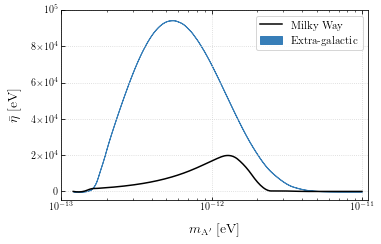

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
plt.grid(ls=':', color='lightgray', alpha=1)

masslist_old = dictKey
ff2 = interpolate.interp1d(masslist_old, avtaulist[0,:]*baseline, kind='quadratic')
ff6 = interpolate.interp1d(masslist_old, avtaulist[1,:]*baseline, kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2,:]*baseline, kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist*baseline, kind='quadratic')
masslist = np.geomspace(masslist_old[masslist_old<=1e-11][0], masslist_old[masslist_old<=1e-11][-1], 200)

#masslistfull = masslist#np.geomspace(masslist_old[0], masslist_old[-1], 100)
#np.save('./data/fullmonopole_gas_z6.npy', [masslistfull, ff6(masslistfull)/baseline + fftau(masslistfull)/baseline])
#np.save('./data/fullmonopole_gas_z10.npy', [masslistfull, ff10(masslistfull)/baseline + fftau(masslistfull)/baseline])

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color=cych[0], alpha=1, label=r'$\rm Extra$-$\rm galactic$')

plt.plot(masslist, fftau(masslist), color='k', ls='-', label=r'$\rm Milky \; Way$')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\eta}  \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_xlim(1e-13, 1.1e-11)
ax.set_xscale('log')
#ax.set_yscale('log')

a=ax.get_yticks().tolist()[1:]
print(a)
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.legend(loc='best')
plt.savefig('./plots/gas_monopoles.pdf', rasterize=True)
plt.show()

[0.0, 40000.0, 80000.0, 120000.0, 160000.0]


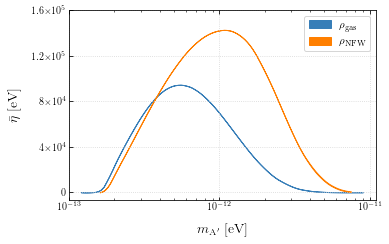

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
plt.grid(ls=':', color='lightgray', alpha=1)

masslist_old = dictKey
ff2 = interpolate.interp1d(masslist_old, avtaulist[0,:]*baseline, kind='quadratic')
ff6 = interpolate.interp1d(masslist_old, avtaulist[1,:]*baseline, kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2,:]*baseline, kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist*baseline, kind='quadratic')
masslist = np.geomspace(masslist_old[masslist_old<1e-11][0], masslist_old[masslist_old<1e-11][-1], 100)

masslist_old_NFW = dictKey_NFW
ff2_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[0,:]*baseline, kind='quadratic')
ff6_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[1,:]*baseline, kind='quadratic')
ff10_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[2,:]*baseline, kind='quadratic')
fftau_NFW = interpolate.interp1d(masslist_old_NFW, NFW_tauMWlist*baseline, kind='quadratic')
masslist_NFW = np.geomspace(masslist_old_NFW[masslist_old_NFW<1e-11][0], masslist_old_NFW[masslist_old_NFW<1e-11][-1], 100)

#np.save('./data/fullmonopole_NFW_z6.npy', [masslist_NFW, ff6_NFW(masslist_NFW)/baseline + fftau_NFW(masslist_NFW)/baseline])
#np.save('./data/fullmonopole_NFW_z10.npy', [masslist_NFW, ff10_NFW(masslist_NFW)/baseline + fftau_NFW(masslist_NFW)/baseline])

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color=cych[0], alpha=1, label=r'$\rho_{\rm gas}$')
plt.fill_between(masslist_NFW, ff6_NFW(masslist_NFW), ff10_NFW(masslist_NFW), color=cych[1], alpha=1, label=r'$\rho_{\rm NFW}$')

MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')

if False:
    xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
    xarg_NFW = np.argmin(np.abs(masslist_NFW-MAMW_rscalelimit))

    plt.plot(masslist[:xarg], fftau(masslist)[:xarg], color='k', ls='-', label=r'$\rm Milky \; Way$')
    plt.plot(masslist[xarg:], fftau(masslist)[xarg:], color='k', ls=':')
    plt.plot(masslist_NFW[:xarg_NFW], fftau_NFW(masslist_NFW)[:xarg_NFW], color='k', ls='-', label=r'$\rm Milky \; Way$')
    plt.plot(masslist_NFW[xarg_NFW:], fftau_NFW(masslist_NFW)[xarg_NFW:], color='k', ls=':')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\eta}  \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_xscale('log')
ax.set_xlim(1e-13, 1.1e-11)

a=ax.get_yticks().tolist()[1::2]
print(a)
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.legend(loc='best')
plt.savefig('./plots/compare_NFW_gas_monopoles.pdf', rasterize=True)
plt.show()


[-20000.0, 0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]
[0.0, 20000.0, 40000.0, 60000.0, 80000.0]


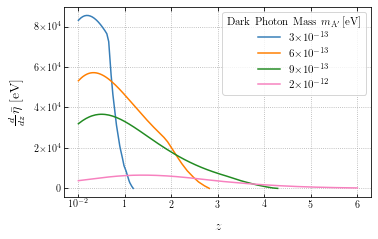

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

cychlic = cycle(cych)

ax.grid(ls=':', color='darkgray', alpha=1)

for mind, MA in enumerate(dictKey):
    if mind in [9, 18, 27, 33]:
        iind = next(cychlic)
        zs2 = zsList[0, mind]
        zs6 = zsList[1, mind]
        dat2 = dtaudzlist[0, mind]*baseline
        dat6 = dtaudzlist[1, mind]*baseline

        zsold = np.concatenate((zs2[zs2<=2.], zs6[zs6>2.]))
        dataold = np.concatenate((dat2[zs2<=2.], dat6[zs6>2.]))
        fint = interpolate.interp1d(zsold, dataold, kind='linear')
        zsnew = np.linspace(zsold[0], zsold[-1], 10000)

        lab2 = r'{}'.format(fmt(MA))
        lss = '-'

        ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, label=lab2)

#ax.set_ylabel(r'$\omega \, \varepsilon^{-2} \, \frac{d}{d z} \bar{\tau}$')
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

a=ax.get_yticks().tolist()
print(a)
a=a[1:-1]
print(a)
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)


a=ax.get_xticks().tolist()[1:-1]
a[0]=1e-2
ax.set_xticks(a)
ax.set_xticklabels([fmt(al) for al in a])

plt.savefig('./plots/gas_dtaudz.pdf', rasterize=True); plt.show()


[-20000.0, 0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0]
[0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]


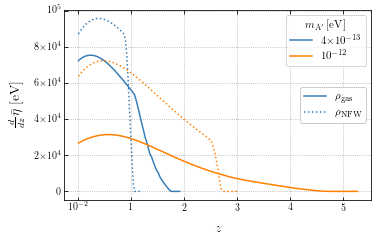

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

cychlic = cycle(cych)

ax.grid(ls=':', color='darkgray', alpha=1)

secondary_lines, secondary_labels = [], []
for mind, MA in enumerate(dictKey):
    if mind in [12, 30]:
            try:
                mind2 = np.argwhere(dictKey_NFW==MA)[0,0]
            except:
                continue

            iind = next(cychlic)
            zs2 = zsList[0, mind]
            zs6 = zsList[1, mind]
            dat2 = dtaudzlist[0, mind]*baseline
            dat6 = dtaudzlist[1, mind]*baseline

            zsold = np.concatenate((zs2[zs2<=2.], zs6[(zs6>2.)&(zs6<=6.)]), axis=0)
            dataold = np.concatenate((dat2[zs2<=2.], dat6[(zs6>2.)&(zs6<=6.)]), axis=0)
            fint = interpolate.interp1d(zsold, dataold, kind='slinear')
            zsnew = np.linspace(zsold[0], zsold[-1], 1000)

            lab2 = r'{}'.format(fmt(MA))
            lss = '-'

            xarg = np.argwhere(dataold==0.).flatten()
            if len(xarg)!=0: xarg = xarg[0]+5
            else: xarg=-1
            l1, = ax.plot(zsold[:xarg], dataold[:xarg], color=iind, ls=lss, label=lab2)

            if mind==12:
                secondary_labels.append(r'$\rho_{\rm gas}$')
                secondary_lines.append(l1)
            #ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, label=lab2)
            #ax.plot(zsnew, fint(zsnew), color=iind, ls=':', label=lab2)

            zs2 = NFW_zsList[0, mind2]
            zs6 = NFW_zsList[1, mind2]
            dat2 = NFW_dtaudzlist[0, mind2]*baseline
            dat6 = NFW_dtaudzlist[1, mind2]*baseline

            zsold = np.concatenate((zs2[zs2<=2.], zs6[(zs6>2.)&(zs6<=6.)]))
            dataold = np.concatenate((dat2[zs2<=2.], dat6[(zs6>2.)&(zs6<=6.)]), axis=0)
            fint = interpolate.interp1d(zsold, dataold, kind='slinear')
            zsnew = np.linspace(zsold[0], zsold[-1], 1000)

            xarg = np.argwhere(dataold==0.).flatten()
            if len(xarg)!=0: xarg = xarg[0]+5
            else: xarg=-1
            l1, = ax.plot(zsold[:xarg], dataold[:xarg], color=iind, ls=':')

            if mind==12:
                secondary_labels.append(r'$\rho_{\rm NFW}$')
                secondary_lines.append(l1)
            #ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, alpha=0.5)
            #ax.plot(zsnew, fint(zsnew), color=iind, ls=':', alpha=0.5)

#for zi, zz in enumerate(ztype):
#    ax.plot(thom_zsList[zi], thom_dtaudzlist[zi], ls=['-', '--', ':'][zi], label=(r'$\frac{d}{d z} \bar{\tau}_{\rm reio}$' if zi==2 else None))

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, framealpha=1, loc='center right'))

#ax.set_ylabel(r'$\omega \, \varepsilon^{-2} \, \frac{d}{d z} \bar{\tau}$')
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

#ax.set_xscale('log')
#ax.set_yscale('log')

a=ax.get_yticks().tolist()
print(a)
a=a[1:-1]
print(a)
ax.set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

a=ax.get_xticks().tolist()[1:-1]
a[0]=1e-2
ax.set_xticks(a)
ax.set_xticklabels([fmt(al) for al in a])

plt.savefig('./plots/compare_NFW_gas_dtaudz.pdf', rasterize=True); plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


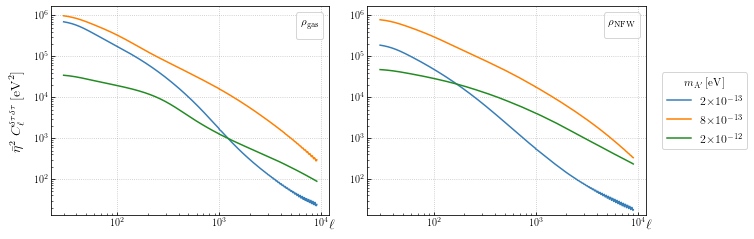

In [22]:
fig = plt.figure(figsize=(10, 3.5))
gs = gridspec.GridSpec(1, 9, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax3 = fig.add_subplot(gs[0, 8:])
ax = [ax1, ax2, ax3]

cychlic = cycle(cych)
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

mm  = 30
mmm = 9000
preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi

oo = 1000
filtr = 10

for mind, MA in list(enumerate(dictKey)):
    if mind in [6, 24, 33]:
        try:
            mind2 = np.argwhere(dictKey_NFW==MA)[0,0]
        except:
            continue

        iind = next(cychlic)
        lab1 = r'{}'.format(fmt(MA))

        testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        ax[0].plot(ells[mm:mmm], preqs*(testx*baseline**2.), alpha=1, color=iind)

        testx1 = gaussian_filter1d(NFW_CellTauTau[1, mind2, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(NFW_CellTauTau[1, mind2, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        ax[1].plot(ells[mm:mmm], preqs*(testx*baseline**2.), color=iind)

        ax[2].plot(ells[mm:mmm], np.ones(len(ells[mm:mmm])), color=iind, label=lab1)

ax[2].legend(fontsize=12, ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$', loc='center')
ax[2].set_xscale('log', subsx=[])
ax[2].set_yscale('log', subsy=[])
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])
ax[2].set_ylim((90, 90.01))
ax[2].set_xlim((90, 90.01))


ax[0].set_ylabel(r'$\bar{\eta}^2 \; C_\ell^{\delta\tau\delta\tau}  \; [{\rm eV}^2]$')
for aa, axx in enumerate(ax[:-1]):
    axx.legend(fontsize=12, ncol=1, title=[r'$\rho_{\rm gas}$', r'$\rho_{\rm NFW}$'][aa], loc=1)
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
    axx.xaxis.set_label_coords(1.01, -0.02)

#ymin, ymax = ax[0].get_ylim()
#ax[0].set_ylim((1e-6,ymax))
ytickslocs = ax[0].get_yticks()
ax[1].axes.get_yaxis().set_ticks(ytickslocs)
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))

plt.savefig('./plots/compare_NFW_gas_celltautau.pdf', rasterize=True)
plt.show()


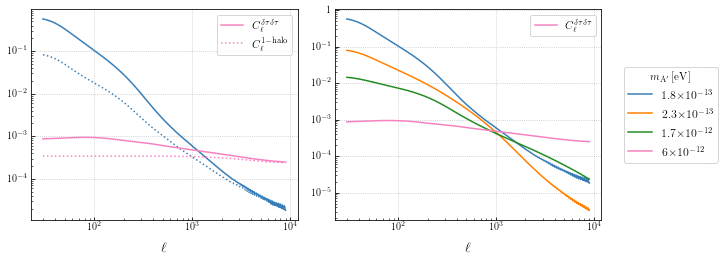

In [23]:
fig = plt.figure(figsize=(10, 3.5))
gs = gridspec.GridSpec(1, 7, figure=fig)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[0, 6:])
ax = [ax1, ax2, ax3]

plt.tight_layout(pad=1., h_pad=None, w_pad=None, rect=None)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
cychlic = cycle(cych)

mm = 30
mmm = 9000

oo = 1000
filtr = 10

ct = 0
for mind, MA in list(enumerate(dictKey)):
    if mind in [4, 7, 32, 37]:
        iind = next(cychlic)
        lab1 = r'{}'.format(fmt(MA))
        
        labtot = (r'$C_\ell^{\delta\tau\delta\tau}$' if ct==3 else None)
        lab1h = (r'$C_\ell^{1-{\rm halo}}$' if ct==3 else None)

        testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        testx1 = gaussian_filter1d(Cell1Hdata[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(Cell1Hdata[1, mind, oo:mmm], filtr*3, mode='nearest')
        testxz = np.concatenate((testx1, testx2))

        if ct in [0,3]:
            ax[0].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=labtot)
            ax[0].plot(ells[mm:mmm], preqs*(testxz), ls=':', alpha=1, color=iind, label=lab1h)

        ax[1].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=labtot)
        ax[2].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=lab1)
        ct += 1

#ax[2].legend(fontsize=12, loc='center', ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[2].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[2].set_xscale('log', subsx=[])
ax[2].set_yscale('log', subsy=[])
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])
ax[2].set_ylim((1.1e50, 2e50))
ax[2].set_xlim((1.1e50, 2e50))

for aa, axx in enumerate(ax[:-1]):
    axx.legend(loc=1)
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log'); axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
  #  axx.xaxis.set_label_coords(1.015, -0.015)
  #  axx.xaxis.set_label_coords(0, -0.015)

a=ax[1].get_yticks().tolist()[2:-2][::]
ax[1].set_yticks(a)
a = [fmt(al) for aind, al in enumerate(a)]
ax[1].set_yticklabels(a)

plt.savefig('./plots/gas_celltautau.pdf', rasterize=True)
plt.show()


In [24]:
if False:
    fig = plt.figure(figsize=(11, 3.5))
    gs = gridspec.GridSpec(1, 10, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax3 = fig.add_subplot(gs[0, 6:9])
    ax4 = fig.add_subplot(gs[0, 9:])
    ax = [ax1, ax2, ax3, ax4]

    mm = 2
    mmm = 9000

    label_list = [r'$C_\ell^{1-{\rm halo}}$', r'$C_\ell^{2-{\rm halo}}$', r'$C_\ell^{\delta\tau\delta\tau}$']
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi

    cychlic = cycle(cych)

    ax[0].plot(ells[mm:mmm], preqs*(thom_Cell1Hdata[mm:mmm]), alpha=1, color='k')
    ax[1].plot(ells[mm:mmm], preqs*(thom_Cell2Hdata[mm:mmm]), alpha=1, color='k')
    ax[2].plot(ells[mm:mmm], preqs*(thom_CellTauTau[mm:mmm]), alpha=1, color='k')

    for mind, MA in reversed(list(enumerate(dictKey))):
        if mind in [4, 7, 32, 37]:
            iind = next(cychlic)
            lab1 = r'{}'.format(fmt(MA))

            ax[0].plot(ells[mm:mmm], preqs*(Cell1Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
            ax[1].plot(ells[mm:mmm], preqs*(Cell2Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
            ax[2].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind)

            ax[0].plot(ells[mm:mmm], preqs*(cross_Cell1H[mind, mm:mmm]), alpha=0.5, color=iind)
            ax[1].plot(ells[mm:mmm], preqs*(cross_Cell2H[mind, mm:mmm]), alpha=0.5, color=iind)
            ax[2].plot(ells[mm:mmm], preqs*(cross_CellTTau[mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))), alpha=0.5, color=iind)

            ax[3].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=lab1)

    ax[3].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[3].set_xscale('log', subsx=[]); ax[3].set_yscale('log', subsy=[])
    ax[3].spines['right'].set_visible(False); ax[3].spines['left'].set_visible(False)
    ax[3].spines['top'].set_visible(False); ax[3].spines['bottom'].set_visible(False)
    ax[3].axes.yaxis.set_ticklabels([]); ax[3].axes.xaxis.set_ticklabels([])
    ax[3].set_ylim((1.1e50, 2e50)); ax[3].set_xlim((1.1e50, 2e50))

    #ax[0].set_ylim(1e-6, 2e-1)

    for aa, axx in enumerate(ax[:-1]):
        axx.tick_params(which='both', axis="y", direction="in")
        axx.tick_params(which='both', axis="x", direction="in")
        axx.set_xlabel(r'$\ell$')
        axx.set_title((r'$\bar{\tau}_g^2 \varepsilon^{-4} \,$' if aa==2 else ' ')+label_list[aa])
        axx.set_xscale('log')
        axx.set_yscale('log')
        axx.grid(ls=':', color='gray', alpha=0.5)
      #  axx.xaxis.set_label_coords(1.015, -0.015)
      #  axx.xaxis.set_label_coords(0, -0.015)
    plt.savefig('./plots/celltautau.pdf', rasterize=True)
    plt.show()


18 6e-13 6e-13 1e-06


/tmp/ipykernel_12340/732190254.py:29: RuntimeWarning: invalid value encountered in divide
  testx1 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[mm:oo], filtr, mode='nearest')
/tmp/ipykernel_12340/732190254.py:30: RuntimeWarning: invalid value encountered in divide
  testx2 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[oo:mmm], filtr*3, mode='nearest')


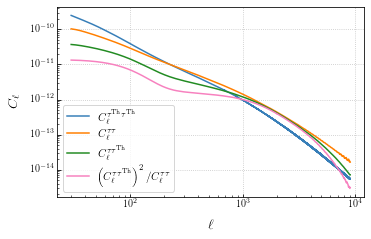

In [25]:
fig = plt.figure(figsize=(5.5, 3.5))
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

lab1 = r'{}'.format(fmt(MA))

mm = 30
mmm = 9000
preqs = 1.#ells[mm:mmm] * (ells[mm:mmm] + 1. ) / 2./np.pi
mind = 18
MA = dictKey[mind]
varep = 1e-6#7e-7
print(mind, dictKey[mind], MA, varep)

oo = 2000
filtr = 5

plt.plot(ells[mm:mmm], preqs*(thom_CellTauTau[mm:mmm]), color=cych[0], label=r'$C_{\ell}^{\tau^{\rm Th} \tau^{\rm Th}}$')

testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*(varep**4. * testx), color=cych[1], label=r'$C_{\ell}^{\tau \tau}$')

testx1 = gaussian_filter1d(cross_CellTTau[mind, mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d(cross_CellTTau[mind, oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*(varep**2. * testx), color=cych[2], label=r'$C_{\ell}^{\tau \tau^{\rm Th}}$')

testx1 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*testx, color=cych[3], label=r'$\left(C_{\ell}^{\tau \tau^{\rm Th}}\right)^2/C_{\ell}^{\tau \tau}$')
plt.legend(loc=3, ncol=1)#, title=r'$\varepsilon=$'+str(fmt(varep)))#+r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'${\rm \, eV}$')

plt.tick_params(which='both', axis="y", direction="in")
plt.tick_params(which='both', axis="x", direction="in")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xscale('log'); plt.yscale('log')
plt.grid(ls=':', color='gray', alpha=0.5)
plt.savefig('./plots/comparison_corrs.pdf', rasterize=True)
plt.show()


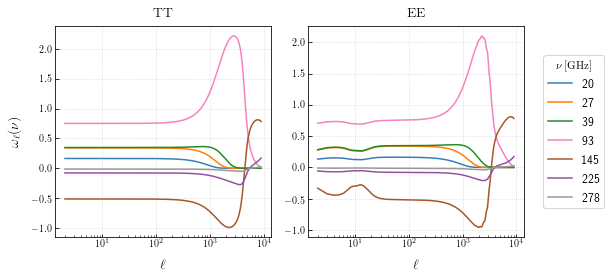

In [26]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname != 'CMBS4': continue
    if expname=='Planck':
        mm = 2
        mmm = 5000
    else:
        mm = 2
        mmm = 9000

    fig = plt.figure(figsize=(8, 3.5))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    mind = 25

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        ILCweights = np.load(weights_path_gas(expname, zreio))

        for jj in range(len(freqs)):
            labfreq = (r'{}'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(ILCweights[ii, mm:mmm, jj]), color=cych[jj], label=labfreq)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1, title=r'$\nu \, [{\rm GHz}]$')
    ax[len(ax)-1].set_xscale('log', subsx=[]); ax[len(ax)-1].set_yscale('log', subsy=[])
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    ax[0].set_ylabel(r'$\omega_\ell(\nu)$')

    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
        if ai==0:
            ax.set_xscale('log')
        elif ai==1:
            ax.set_xscale('log')
        elif ai==2:
            ax.set_xscale('log')
      #  ax.xaxis.set_label_coords(1.015, -0.015)
        ax.grid(ls=':', color='darkgray', alpha=0.5)
    plt.savefig('./plots/weights'+str(expname)+'.pdf', rasterize=True)
    plt.show()

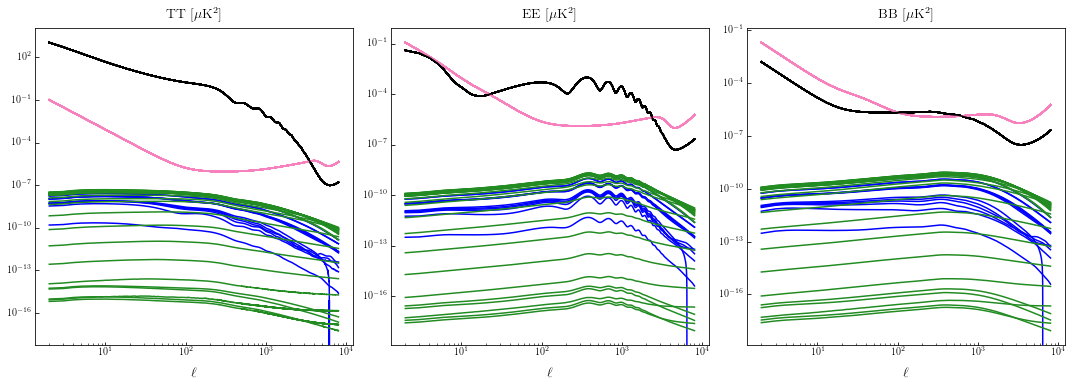

In [27]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname!='CMBS4': continue

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 12, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for mind in range(len(dictKey)):
        MA = dictKey[mind]
        if mind in [0,1]:
            continue
        elif MA < 5e-13:
            col = 'b'
        else:
            col = cych[2]

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
        BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

        mm = 2
        mmm = 8000

        for ii, ij in enumerate(np.arange(len(ax))):
            if ii==0:
                epsilon = 5e-7 #8e-11 # TT
            else:
                epsilon = 5e-6 #7e-7  # EE, TE

            ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[3])
            ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k')
            ax[ii].plot(ells[mm:mmm], preqs*(epsilon**2. * cross_Screening[mind, ij, mm:mmm]), color=col, ls='-', alpha=1)

            
    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


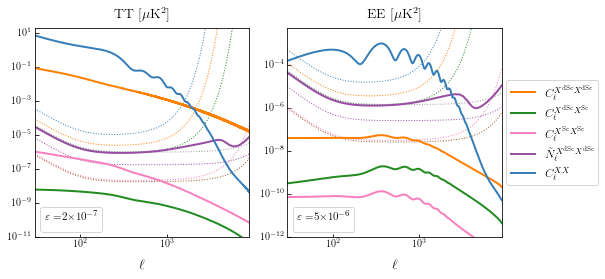

In [28]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname!='CMBS4': continue

    mind = 20
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
    BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

    mm = 30
    mmm = 9000
    
    fig = plt.figure(figsize=(8, 3.5))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = (r'$C_{\ell}^{XX}$' if ii==len(ax)-1 else None)
        lab4 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab5 = (r'$C_{\ell}^{X^{\rm Sc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab2 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)
        lab3 = (r'$\tilde{N}_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)

        for jj in range(len(freqs)):
            labfreq = ('{} GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cych[jj], linewidth=1, ls=':')

        if ii==0:
            epsilon = 2e-7 #8e-11 # TT
        elif ii==1:
            epsilon = 5e-6 #7e-7  # EE, TE

        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), color=cych[1], linewidth=2, ls='-', label=lab2)
        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**2. * cross_Screening[mind, ij, mm:mmm]), color=cych[2], linewidth=2, ls='-', label=lab4)
        ax[ii].plot(ells[mm:mmm], preqs*(thom_Screening[ij, mm:mmm]), color=cych[3], linewidth=2, ls='-', label=lab5)
        ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[5], linewidth=2, label=lab3)
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], linewidth=2, label=lab0)
    #    ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k', label=lab3, ls=':')

        ax[ii].legend(title=r'$\varepsilon=$'+str(fmt(epsilon)),loc=3)# + r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'$ \, [{\rm eV}]$', loc=1)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1)#, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[len(ax)-1].set_xscale('log', subsx=[]); ax[len(ax)-1].set_yscale('log', subsy=[])
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        if ai==0:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((1e-11,20))
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((1e-12,5e-3))
    #    ax.xaxis.set_label_coords(1.015, -0.015)
    #    ax.grid(ls=':', color='darkgray', alpha=0.5)
       # ax.yaxis.set_ticks_position('both')
       # ax.xaxis.set_ticks_position('both')
        ax.minorticks_off()
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

#### Contour Plot

(44, 3, 4)


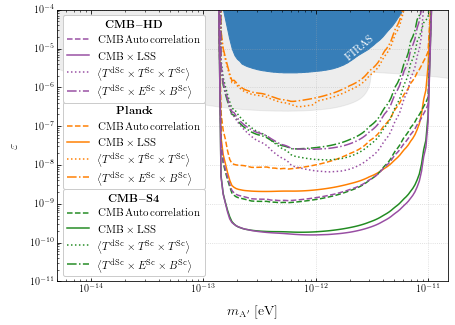

In [29]:
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
           #   r'${\rm Reconstruction} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

fig, ax = plt.subplots(1,1, figsize = (7,5))
lssss = ['--', '-', ':', '-.', ':']

masslist_old = [1.19e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.19e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]

datashape = np.shape(sigmaEpsilonList); print(datashape)
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    secondary_lines, secondary_labels = [], []

    for method in range(datashape[-1]):
        col = [cych[1], cych[2], cych[5]][eind]
        lss = lssss[method]

        if method>=2:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.4, mode='nearest')
            sigmaEpsilonList[6, eind, method] = 2*sigmaEpsilonList[7, eind, method]
            sigmaEpsilonList[8, eind, method] = 0.5*(sigmaEpsilonList[7, eind, method] + sigmaEpsilonList[9, eind, method])
            sigmaEpsilonList[12, eind, method] = 0.5*(sigmaEpsilonList[11, eind, method] + sigmaEpsilonList[13, eind, method])
            sigmaEpsilonList[18, eind, method] = 0.5*(sigmaEpsilonList[17, eind, method] + sigmaEpsilonList[19, eind, method])
            list2intp1 = gaussian_filter1d(sigmaEpsilonList[3:30, eind, method], 0.8, mode='nearest')
            list2intp2 = gaussian_filter1d(sigmaEpsilonList[30:-1, eind, method], 0.01, mode='nearest')
            list2intp3 = gaussian_filter1d(sigmaEpsilonList[-1:, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + list2intp1.tolist() + list2intp2.tolist() + list2intp3.tolist()
        else:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + sigmaEpsilonList[3:, eind, method].tolist()
            
        ff = interpolate.interp1d(masslist_old, 1./np.asarray(list2intp), kind='linear')
        list2plot1 = 1./ff(masslist)

       # l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss)
        l1, = plt.plot(masslist, list2plot1, color=col, ls=lss)
        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, fancybox=True, framealpha=1, loc=['center left',3,2][eind]))
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

xvals, firasz6 = np.load('./data/gas_contour.npy')
plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), color=cych[0])
plt.text(1.8e-12, 5e-6, r'$\rm FIRAS$', color='white', weight="bold", rotation=40)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((5e-15, 1.5e-11))
plt.ylim((10e-12, 1e-4))
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.savefig('./plots/gas_contours.pdf', rasterize=True)
plt.show()


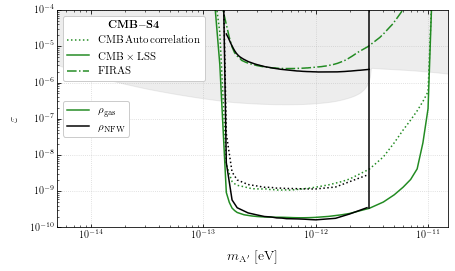

In [30]:
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$',\
              r'$\rm FIRAS$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

fig, ax = plt.subplots(1,1, figsize = (7,4))
lssss = [':', '-', '-', '-', '-.']
secondary_lines, secondary_labels = [], []

#plt.axvline(MAMW_rscalelimit)

masslist_old = [1.15e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.15e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]
datashape = np.shape(sigmaEpsilonList)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue

    for method in range(datashape[-1] + 1):
        if method==2 or method==3: continue
        
        col = [cych[1], cych[2], cych[5]][eind]
        lss = lssss[method]

        if method < datashape[-1]:
            l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss, label=constraint[method])

            if method==1:
                secondary_labels.append(r'$\rho_{\rm gas}$')
                secondary_lines.append(l1)
        else:
            xvals, firas = np.load('./data/gas_contour.npy')
            l1, = plt.plot(xvals, firas, color=col, ls=lss, label=constraint[method])

constraint = [r'$\rm CMB \, Autocorrelation$', r'${\rm CMB} \times {\rm LSS}$', r'$\rm FIRAS$']

xmn = np.argmin(np.abs(dictKey_NFW - MAMW_rscalelimit))
masslist_old = [1.5e-13]+dictKey_NFW.tolist()+[1e-11]
masslist = [1.5e-13]+np.geomspace(dictKey_NFW[dictKey_NFW<=1e-11][0], dictKey_NFW[dictKey_NFW<=1e-11][-1], 100).tolist()+[1.1e-11]
datashape = np.shape(sigmaEpsilonList_NFW)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue

    for method in range(datashape[-1]+1):
        col = 'k'
        lss = lssss[method]

        if method < datashape[-1]:
            l1, = plt.plot(masslist_old[:xmn+2], sigmaEpsilonList_NFW[:xmn+2, eind, method], color=col, ls=lss)

            if method==1:
                secondary_labels.append(r'$\rho_{\rm NFW}$')
                secondary_lines.append(l1)
                
                thg = sigmaEpsilonList_NFW[xmn+1, eind, method]
                
                lext1 = masslist_old[xmn+1:-3]
                lext2 = np.linspace(masslist_old[-3], MAMWlimit, 50)
    
                yext1 = sigmaEpsilonList_NFW[xmn+1:-3, eind, method]
                yext2 = sigmaEpsilonList_NFW[-3, eind, method]*np.linspace(1, 2, len(lext2))

                lext = np.concatenate((lext1, lext2))
                yext = np.concatenate((yext1, yext2))
                
            #    plt.fill_between(lext, yext, 1e-3*np.ones(len(yext)), edgecolor='lightgray', facecolor='none', hatch='x')
        else:
            xvals, firas = np.load('./data/NFW_contour.npy')
            xmn1 = np.argmin(np.abs(xvals - MAMW_rscalelimit*1.05))
            l1, = plt.plot(xvals[:xmn1], firas[:xmn1], color=col, ls=lss)

plt.plot(np.ones(100)*MAMW_rscalelimit*1.05, np.linspace(1e-3, thg, 100), color='k', ls='-')

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, framealpha=1, loc='center left'))
plt.legend(title=r'$\rm \mathbf{CMB{-}S4}$', fancybox=True, framealpha=1, loc=2)

jhdata = np.genfromtxt('./data/DPlimits.txt')
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((5e-15, 1.5e-11))
plt.ylim((10e-11, 1e-4))
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.savefig('./plots/gasvsNFW_contours.pdf', rasterize=True)
plt.show()

